# Import and Cleaning

In [29]:
# adding path to import custom functions
import sys
sys.path.append("/home/artur/code/masters-project/main_project/notebooks/model_creation")

In [30]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from time import perf_counter, gmtime, strftime

from functions import remove_high_corr, scale_variables, best_params_grid, calculate_confusion_matrix, plot_roc_auc_curve, bart_auc_scorer, make_label, get_error_and_auc

from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.model_selection import RepeatedKFold, train_test_split, cross_val_score, GridSearchCV, RepeatedStratifiedKFold

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, make_scorer

from ISLP.bart import BART

import session_info 

In [31]:
data = pd.read_csv("../data/pre_processed_pdb_padel_no_inputation.csv")
data.head()

/tmp/ipykernel_569210/2554489317.py:1: DtypeWarning: Columns (0,1,3,4,5,6,7,8,9,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("../data/pre_processed_pdb_padel_no_inputation.csv")


,name,chembl_id,clean_smiles,first_approval_year,indication_class,molecule_type,withdrawn_flag,therapeutic_flag,polymer_flag,inorganic_flag,...,JGI8,JGI9,JGI10,VE1_D,VE2_D,VR1_D,VR2_D,SRW5,XLogP,fda_approved
0,GUANIDINE HYDROCHLORIDE,CHEMBL1200728,N=C(N)N,1939,NaN,Small molecule,False,True,False,False,...,0.0,0.0,0.0,1.110223e-16,2.775558e-17,3.000000e+06,750000.000000,0.0,-0.646,1.0
1,ACETOHYDROXAMIC ACID,CHEMBL734,CC(=O)NO,1983,Enzyme Inhibitor (urease),Small molecule,False,True,False,False,...,0.0,0.0,0.0,6.081016e-02,1.216203e-02,1.237595e+01,2.475191,0.0,-0.728,1.0
2,HYDROXYUREA,CHEMBL467,NC(=O)NO,1967,Antineoplastic,Small molecule,False,True,False,False,...,0.0,0.0,0.0,6.081016e-02,1.216203e-02,1.237595e+01,2.475191,0.0,-1.606,1.0
3,CYSTEAMINE,CHEMBL602,NCCS,1994,CYSTEAMINE HYDROCHLORIDE,Small molecule,False,True,False,False,...,0.0,0.0,0.0,0.000000e+00,0.000000e+00,8.452347e+00,2.113087,0.0,0.106,1.0
4,DIMETHYL SULFOXIDE,CHEMBL504,C[S+](C)[O-],1978,Anti-Inflammatory (topical),Small molecule,False,True,False,False,...,0.0,0.0,0.0,1.110223e-16,2.775558e-17,3.000000e+06,750000.000000,0.0,-0.786,1.0


In [32]:
Y = data["fda_approved"]
Y = Y.astype(float)
Y.head()

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: fda_approved, dtype: float64

In [33]:
X = data.iloc[:, 14:-1]
X.head()

,nAcid,ALogP,ALogp2,AMR,naAromAtom,nB,nN,nO,nS,nP,...,JGI7,JGI8,JGI9,JGI10,VE1_D,VE2_D,VR1_D,VR2_D,SRW5,XLogP
0,0.0,-0.4695,0.220430,11.1997,0.0,0.0,3.000000e+00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.110223e-16,2.775558e-17,3.000000e+06,750000.000000,0.0,-0.646
1,0.0,-1.0852,1.177659,15.4305,0.0,0.0,1.000000e+00,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.081016e-02,1.216203e-02,1.237595e+01,2.475191,0.0,-0.728
2,0.0,-1.0880,1.183744,12.5072,0.0,0.0,2.000000e+00,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.081016e-02,1.216203e-02,1.237595e+01,2.475191,0.0,-1.606
3,0.0,-0.2157,0.046526,22.3381,0.0,0.0,1.000000e+00,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,8.452347e+00,2.113087,0.0,0.106
4,0.0,-0.5895,0.347510,11.3934,0.0,0.0,4.440892e-16,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.110223e-16,2.775558e-17,3.000000e+06,750000.000000,0.0,-0.786


In [34]:
# separate train an test datasets

np.random.seed(750059)
x_train, x_test, y_train, y_test = train_test_split(X, Y, stratify=Y, test_size=0.25)

# Constant Variables

In [35]:
DESCRIPTOR_TYPE = "padel_no_inputation"

# Scaling datsets

The datasets are being scaled to be used, when necessary, scaled

In [36]:
# TRAIN

x_train_scaled = scale_variables(x_train)

# adding constant
x_train_scaled = sm.add_constant(x_train_scaled)

x_train_scaled.head()

,const,nAcid,ALogP,ALogp2,AMR,naAromAtom,nB,nN,nO,nS,...,JGI7,JGI8,JGI9,JGI10,VE1_D,VE2_D,VR1_D,VR2_D,SRW5,XLogP
0,1.0,-0.473195,-0.030479,-0.221190,-0.470054,-0.137303,-0.084773,0.422037,-0.331856,1.150272,...,0.641735,0.670047,1.366458,0.090146,-0.299188,-0.122968,-0.131482,-0.137216,1.097039,-0.766699
1,1.0,-0.473195,0.520670,-0.286440,-0.220667,-0.566833,-0.084773,-0.148206,-0.566398,-0.497256,...,-0.145890,0.332940,1.173431,0.343233,0.901368,1.770855,-0.131519,-0.137244,-1.057251,-0.377862
2,1.0,-0.473195,0.528620,-0.286366,-0.176537,1.151289,-0.084773,0.707159,-0.566398,-0.497256,...,-0.161255,-0.095348,-0.579776,0.144212,0.162644,-0.077516,-0.131150,-0.137083,-1.057251,0.497877
3,1.0,0.580312,0.682689,-0.279228,0.174235,0.292228,-0.084773,-0.718449,0.137228,-0.497256,...,0.184472,1.157659,0.042180,1.095440,2.535084,2.127417,-0.131333,-0.137194,-1.057251,0.553751
4,1.0,-0.473195,-0.382508,-0.106887,-0.629776,-0.137303,-0.084773,0.422037,-0.331856,-0.497256,...,1.176028,1.195886,-0.555114,-1.403685,0.770885,1.876214,-0.131528,-0.137237,0.639489,-1.194591


In [37]:
# TEST

x_test_scaled = scale_variables(x_test)

# adding constant
x_test_scaled = sm.add_constant(x_test_scaled)

x_test_scaled.head()

,const,nAcid,ALogP,ALogp2,AMR,naAromAtom,nB,nN,nO,nS,...,JGI7,JGI8,JGI9,JGI10,VE1_D,VE2_D,VR1_D,VR2_D,SRW5,XLogP
0,1.0,-0.512604,0.416990,-0.310324,1.396078,-1.375260,-0.073324,-0.728832,-0.060372,1.124859,...,0.190819,0.168352,0.411172,0.601873,3.568011,2.460955,-0.086918,-0.121584,1.098691,0.747416
1,1.0,0.656383,0.204565,-0.289939,-0.962307,-1.375260,-0.073324,-1.031299,-0.316955,-0.478408,...,-2.389376,-1.941488,-1.618274,-1.376510,-1.123689,-1.189232,-0.087190,-0.121735,-1.092360,-0.911611
2,1.0,-0.512604,0.714562,-0.301084,-0.670262,0.353638,-0.073324,-0.123898,-1.086703,-0.478408,...,-0.482231,1.888769,-1.618274,-1.376510,-0.943493,-0.936882,-0.087037,-0.121574,-1.092360,0.336296
3,1.0,1.825371,0.177159,-0.285671,0.886873,-1.375260,-0.073324,-1.031299,0.965959,-0.478408,...,0.680382,1.355566,1.290270,1.016211,0.648013,0.361469,-0.086848,-0.121502,0.633333,-0.890536
4,1.0,-0.512604,0.681074,-0.304326,-0.310800,0.065489,-0.073324,-0.123898,-1.086703,-0.478408,...,-0.297746,-0.195017,0.213304,0.072217,1.111603,1.656532,-0.087046,-0.121604,-1.092360,0.495104


# Logistic Regression

## Model Constant Variables

In [38]:
model_name_title = "Logistic Regression"
model_name_path = "logistic_regression"

## Cross Validation

Here, I will use the best_params_grid function, which looks for the best hyperparameters, using CV. There are no hyperparameters in Logistic Regression, so this function will only perform CV.

In [39]:
model_params_lr = {
    'Logistic Regression': {
        'model': LogisticRegression(),
        'params': {}
    }
}

In [40]:
gs_result_lr, gs_result_lr_full = best_params_grid(x_train, y_train, model_params_lr)

Starting Grid Search for Logistic Regression: 14:42


/home/artur/Programs/mambaforge/envs/islp/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/artur/Programs/mambaforge/envs/islp/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

Finished Grid Search for Logistic Regression: 14:42
Tempo de execução:  0.1 minutos


/home/artur/Programs/mambaforge/envs/islp/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [41]:
gs_result_lr

,model,best_score,best_params
0,Logistic Regression,0.66182,{}


## Calculating Logistic Regression in R

## Saving Datasets to use in R

The logistic regression calculation was presenting problems in Python, so it will be performed in R, in a separate notebook, saved in the folder `logistic_regression`. Here, I will save the training and test datasets, to use them in R.

In [42]:
# reseting indices
x_train_scaled = x_train_scaled.reset_index()
x_test_scaled = x_test_scaled.reset_index()

y_train = y_train.reset_index()
y_test = y_test.reset_index()

In [43]:
# joining x and y training and test datasets
train = pd.concat([x_train_scaled, y_train], axis=1).drop(["index"], axis=1)
test = pd.concat([x_test_scaled, y_test], axis=1).drop(["index"], axis=1)

In [44]:
# saving datasets
train.to_csv(f"logistic_regression/data/train_{DESCRIPTOR_TYPE}.csv")
test.to_csv(f"logistic_regression/data/test_{DESCRIPTOR_TYPE}.csv")

In [45]:
train.shape

(2803, 555)

## Importing results from R

In [46]:
results_log_reg_df = pd.read_csv(f"logistic_regression/data/lr_coefficients_{DESCRIPTOR_TYPE}.csv")
results_log_reg_df.head()

,Unnamed: 0,Estimate,Std. Error,z value,Pr(>|z|)
0,(Intercept),0.581557,11.161248,0.052105,0.958445
1,X,-0.000156,0.000093,-1.671794,0.094565
2,nAcid,0.086113,0.300095,0.286952,0.774149
3,ALogP,1.841585,0.664501,2.771382,0.005582
4,ALogp2,2.434869,0.586940,4.148413,0.000033


In [47]:
# y predict in test set
y_predict_lr_prob = pd.read_csv(f"logistic_regression/data/y_predict_proba_test_{DESCRIPTOR_TYPE}.csv")
y_predict_lr_prob = y_predict_lr_prob["x"]
y_predict_lr_prob.head()

0    2.220446e-16
1    1.000000e+00
2    2.220446e-16
3    2.220446e-16
4    2.220446e-16
Name: x, dtype: float64

In [48]:
# here I use the make_label function to transform the probabilities into labels, using 0.5 as a cutoff

make_label_v = np.vectorize(make_label)
y_predict_labels_lr = make_label_v(y_predict_lr_prob)

In [49]:
# y predict in training set
y_predict_lr_prob_train = pd.read_csv(f"logistic_regression/data/y_predict_proba_train_{DESCRIPTOR_TYPE}.csv")
y_predict_lr_prob_train = y_predict_lr_prob_train["x"]
y_predict_lr_prob_train.head()

0    0.090497
1    0.945425
2    0.109969
3    0.941039
4    0.920758
Name: x, dtype: float64

## Get Training Error and AUC

In [50]:
mis_rate_lr_train, auc_lr_train = get_error_and_auc(
    model=y_predict_lr_prob_train, 
    x=x_train_scaled,
    y_true=y_train["fda_approved"],
    transform_prob_into_label=True,
    log_reg=True
)

Training Misclassification Rate: 0.1281
Training AUC: 0.8719


## Test Error

In [51]:
mis_rate_lr, disp = calculate_confusion_matrix(
    y_test=y_test["fda_approved"], 
    y_pred=y_predict_labels_lr,
)

Misclassification rate: 0.5358


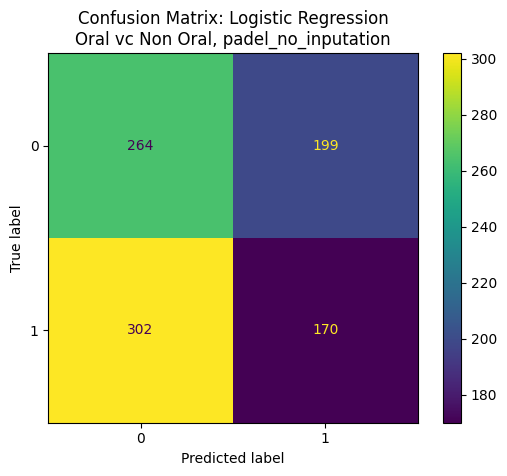

In [52]:
disp.plot()
plt.title(f"Confusion Matrix: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}")
disp.figure_.savefig(f"imgs/cm_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)
plt.show()

## ROC/AUC

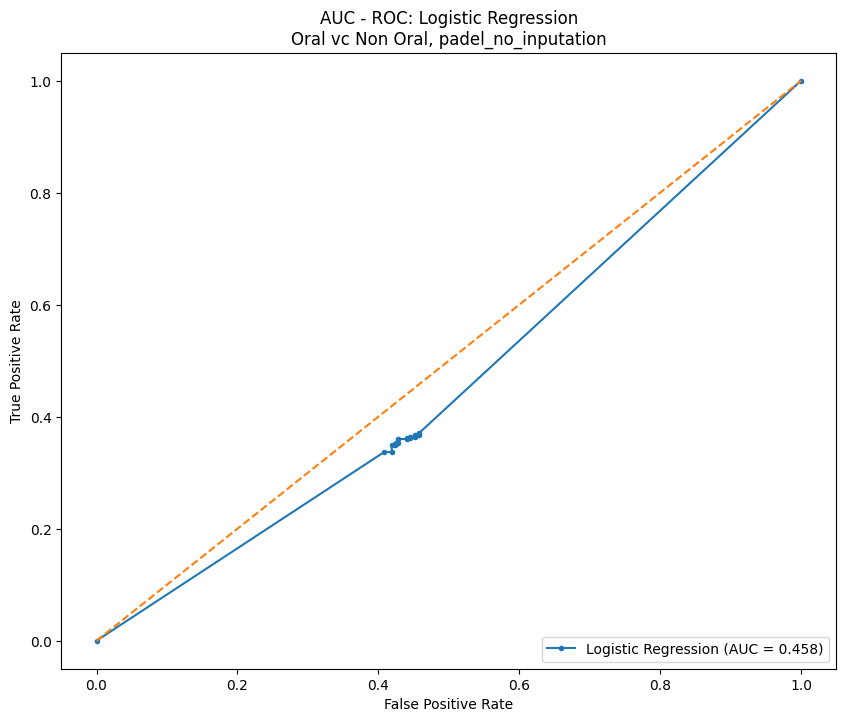

In [53]:
auc_lr = plot_roc_auc_curve(
    y_test=y_test["fda_approved"],
    y_pred=y_predict_lr_prob,
    model_name=model_name_title,
    title=f"AUC - ROC: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}",
    save_path=f"imgs/roc_auc_{DESCRIPTOR_TYPE}_{model_name_path}"
)

## Feature Importance

In [54]:
# converting results summary to pandas dataframe
results_log_reg_df = results_log_reg_df.rename(columns={"Unnamed: 0": "descriptor_name"})
results_log_reg_df = results_log_reg_df.set_index(results_log_reg_df["descriptor_name"]).drop("descriptor_name", axis=1)
results_log_reg_df.shape
results_log_reg_df.head()

,Estimate,Std. Error,z value,Pr(>|z|)
descriptor_name,,,,
(Intercept),0.581557,11.161248,0.052105,0.958445
X,-0.000156,0.000093,-1.671794,0.094565
nAcid,0.086113,0.300095,0.286952,0.774149
ALogP,1.841585,0.664501,2.771382,0.005582
ALogp2,2.434869,0.586940,4.148413,0.000033


In [55]:
important_features_lr = results_log_reg_df[results_log_reg_df["Pr(>|z|)"] < 0.05]
important_features_lr = important_features_lr.reindex(important_features_lr['Estimate'].abs().sort_values(ascending=False).index)
print(important_features_lr.shape)
important_features_lr

(115, 4)


,Estimate,Std. Error,z value,Pr(>|z|)
descriptor_name,,,,
AATS0e,15.924008,6.755449,2.357209,0.018413
AATS1i,12.737194,3.277289,3.886503,0.000102
AATSC5c,-11.944486,3.819858,-3.126945,0.001766
AATS0i,-11.755186,4.412519,-2.664053,0.007721
ATSC4c,10.980267,3.032832,3.620467,0.000294
...,...,...,...,...
JGI8,0.342106,0.126431,2.705876,0.006812
nF12Ring,-0.318995,0.133864,-2.382979,0.017173
minHBint4,-0.303528,0.126089,-2.407250,0.016073


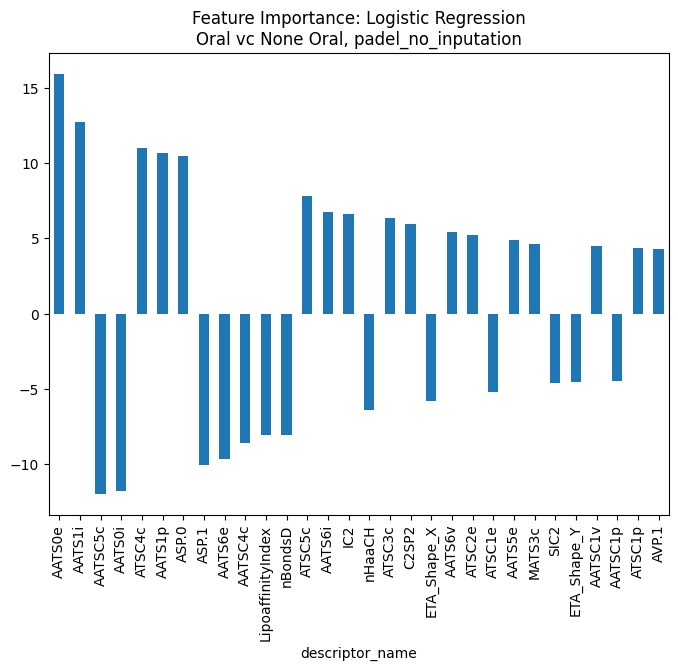

In [56]:
# Print the feature importances

fig, ax = plt.subplots(1, 1)

important_features_lr.iloc[:30,0].plot(kind='bar', figsize=(8,6), ax=ax)
ax.set_title(f"Feature Importance: {model_name_title}\nOral vc None Oral, {DESCRIPTOR_TYPE}")

fig.savefig(f"imgs/feature_importance_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)

## Saving Results

In [57]:
# creating dataset to store final results from each model
final_results = pd.DataFrame(
    columns=[
        "model_name", 
        "cv_test_auc", 
        "training_mis_rate", 
        "test_mis_rate", 
        "training_auc",
        "test_auc"
    ]
)

In [58]:
final_results.loc[len(final_results.index)] = [
    model_name_title,
    gs_result_lr["best_score"][0],
    mis_rate_lr_train,
    mis_rate_lr,
    auc_lr_train,
    auc_lr
]
final_results

,model_name,cv_test_auc,training_mis_rate,test_mis_rate,training_auc,test_auc
0,Logistic Regression,0.66182,0.128077,0.535829,0.871894,0.457952


In [59]:
important_features_lr.to_csv(f"final_results/important_features_{model_name_path}_{DESCRIPTOR_TYPE}.csv", index=False)

# TREES

# Decision Tree

## Model Constant Variables

In [32]:
model_name_title = "Decision Tree"
model_name_path = "decision_tree"

## Hyperparameter Fine Tuning

In [33]:
model_params = {
    'Decision Tree': {
        'model': DecisionTreeClassifier(),
        'params': {
            'criterion': ['gini', 'entropy', 'log_loss'],
            'max_depth': [1, 5, 10, 20, 50, 100, 150],
            'ccp_alpha': [0, 0.0001, 0.001, 0.1, 0.5, 1]
        }
    }
}

In [34]:
gs_result_dt, gs_result_dt_full = best_params_grid(x_train, y_train, model_params)

Starting Grid Search for Decision Tree: 09:11
Finished Grid Search for Decision Tree: 09:55
Tempo de execução:  44.3 minutos


In [35]:
gs_result_dt

,model,best_score,best_params
0,Decision Tree,0.753712,"{'ccp_alpha': 0.001, 'criterion': 'entropy', '..."


## Fitting Tree

In [36]:
decision_tree_params = gs_result_dt.iloc[0,2]
decision_tree_params

{'ccp_alpha': 0.001, 'criterion': 'entropy', 'max_depth': 5}

In [37]:
decision_tree = DecisionTreeClassifier(**decision_tree_params).fit(x_train, y_train)

## Get Training Error and AUC

In [38]:
mis_rate_dt_train, auc_dt_train = get_error_and_auc(
    model=decision_tree, 
    x=x_train,
    y_true=y_train,
)

Training Misclassification Rate: 0.2515
Training AUC: 0.7479


## Make Predictions

In [39]:
y_predict_dt_label = decision_tree.predict(x_test)
y_predict_dt_prob = decision_tree.predict_proba(x_test)[:, 1]

## Test Error

In [40]:
mis_rate_dt, disp = calculate_confusion_matrix(
    y_test=y_test, 
    y_pred=y_predict_dt_label,
)

Misclassification rate: 0.3134


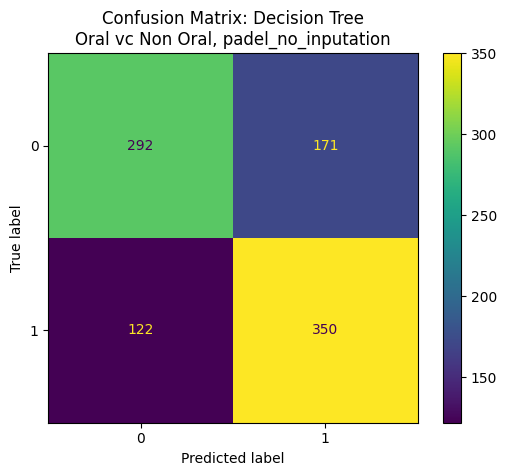

In [41]:
disp.plot()
plt.title(f"Confusion Matrix: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}")
disp.figure_.savefig(f"imgs/cm_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)
plt.show()

## ROC/AUC

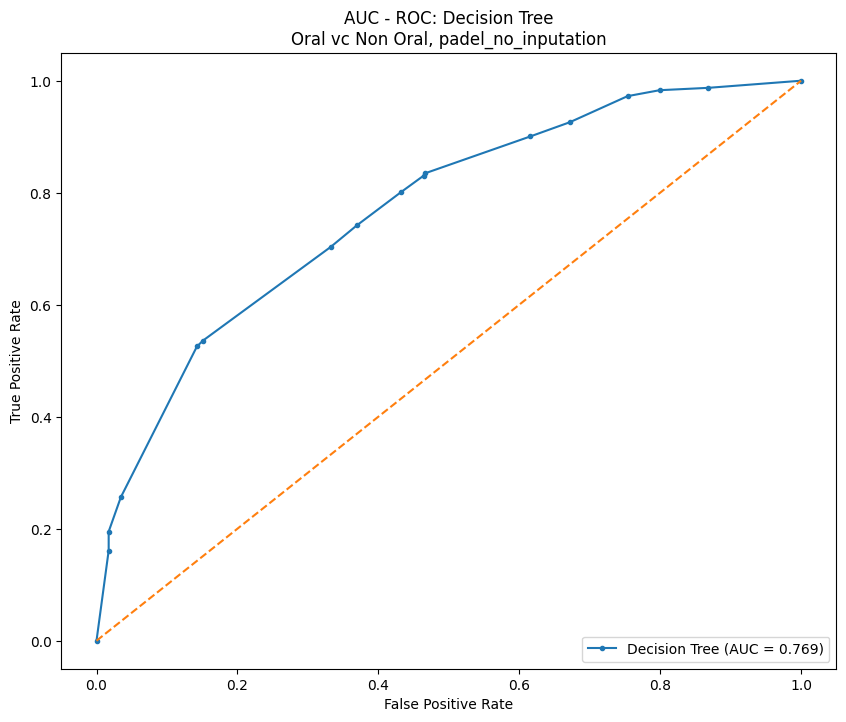

In [42]:
auc_dt = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_dt_prob,
    model_name=model_name_title,
    title=f"AUC - ROC: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}",
    save_path=f"imgs/roc_auc_{DESCRIPTOR_TYPE}_{model_name_path}"
)

## Visualizing the Tree

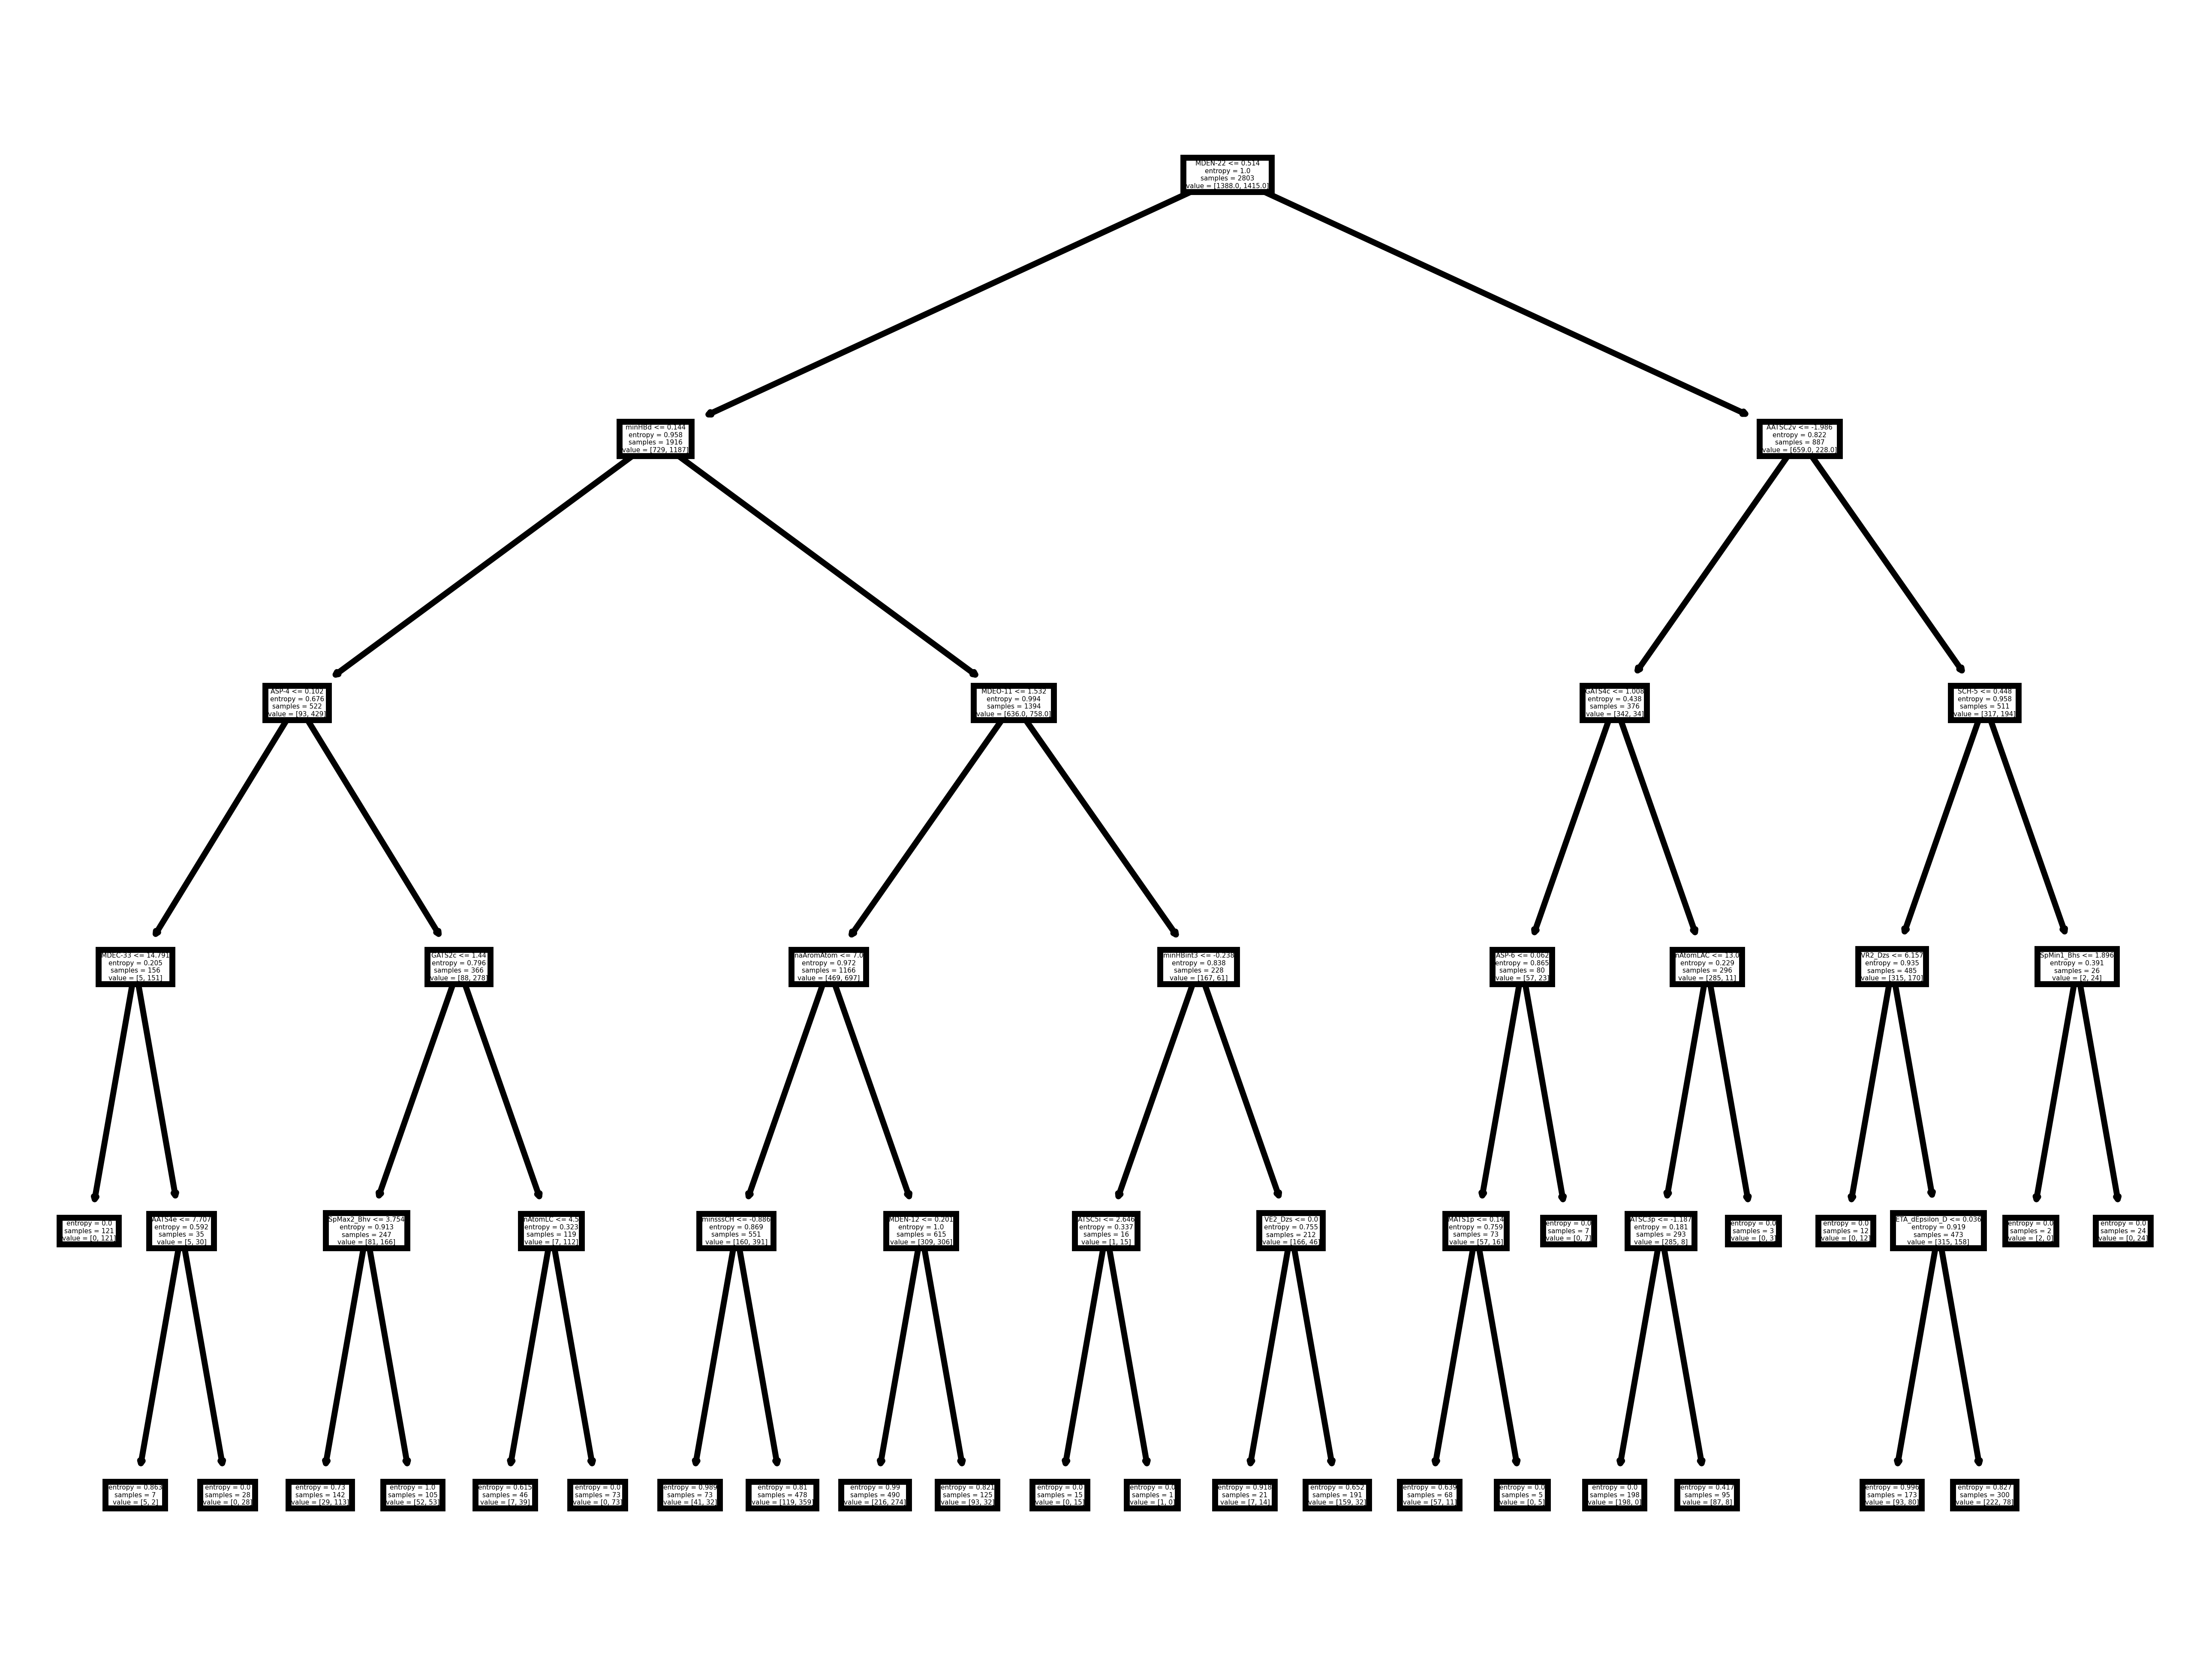

In [43]:
fig, ax = plt.subplots()
fig.dpi = 1000

tree.plot_tree(decision_tree, ax=ax, feature_names=list(x_train.columns))
plt.show()

fig.savefig(f"imgs/decision_tree_{DESCRIPTOR_TYPE}", dpi=1000)

## Feature Importance

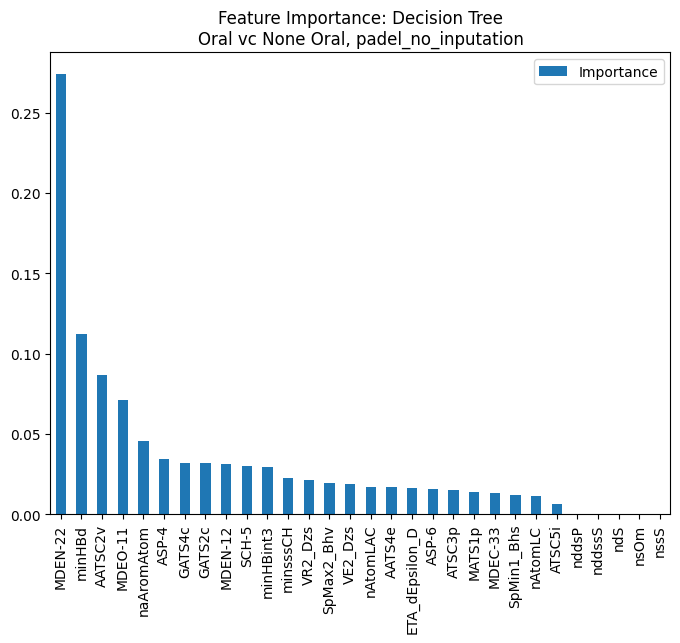

In [44]:
# Print the feature importances

fig, ax = plt.subplots(1, 1)

feat_importances = pd.DataFrame(decision_tree.feature_importances_, index=x_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)

feat_importances.iloc[:30,:].plot(kind='bar', figsize=(8,6), ax=ax)
ax.set_title(f"Feature Importance: {model_name_title}\nOral vc None Oral, {DESCRIPTOR_TYPE}")

fig.savefig(f"imgs/feature_importance_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)

In [45]:
important_features_dt = feat_importances[feat_importances.Importance > 0].sort_values(by="Importance")
important_features_dt

,Importance
ATSC5i,0.006233
nAtomLC,0.011673
SpMin1_Bhs,0.011749
MDEC-33,0.012942
MATS1p,0.013818
ATSC3p,0.015408
ASP-6,0.016003
ETA_dEpsilon_D,0.016595
AATS4e,0.016940
nAtomLAC,0.017187


## Saving Results

In [46]:
final_results.loc[len(final_results.index)] = [
    model_name_title,
    gs_result_dt["best_score"][0],
    mis_rate_dt_train,
    mis_rate_dt,
    auc_dt_train,
    auc_dt
]
final_results

,model_name,cv_test_auc,training_mis_rate,test_mis_rate,training_auc,test_auc
0,Logistic Regression,0.661820,0.160542,0.265241,0.839463,0.802545
1,Decision Tree,0.753712,0.251516,0.313369,0.747928,0.769393


In [47]:
important_features_dt.to_csv(f"final_results/important_features_{model_name_path}_{DESCRIPTOR_TYPE}.csv", index=False)

# Random Forest and Bagging

Bagging is just Random Forest, in which max_features is equal to the total number of features. Therefore, bagging will be done in the RF algorithm, and compared to RF.

## Model Constant Variables

In [48]:
model_name_title = "Random Forest"
model_name_path = "random_forest"

## Hyperparameter Fine Tuning

In [49]:
model_params = {
    'Random Forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [100, 500, 1000], # number of trees
            'max_depth': [10, 50, 100],
            'max_features': ["sqrt", "log2"], # m, number of features considered in split. When it is equal to all predictor of dataset, it is bagging
            'ccp_alpha': [0, 0.1, 0.5]
        }
    }
}

In [50]:
gs_result_rf, gs_result_rf_full = best_params_grid(x_train, y_train, model_params)

Starting Grid Search for Random Forest: 09:55
Finished Grid Search for Random Forest: 13:43
Tempo de execução:  227.4 minutos


In [51]:
gs_result_rf

,model,best_score,best_params
0,Random Forest,0.861295,"{'ccp_alpha': 0, 'max_depth': 100, 'max_featur..."


## Fitting Model

In [52]:
random_forest_params = gs_result_rf.iloc[0,2]
random_forest_params

{'ccp_alpha': 0,
 'max_depth': 100,
 'max_features': 'sqrt',
 'n_estimators': 1000}

In [53]:
random_forest = RandomForestClassifier(**random_forest_params).fit(x_train, y_train)

## Get Training Error and AUC

In [54]:
mis_rate_rf_train, auc_rf_train = get_error_and_auc(
    model=random_forest, 
    x=x_train,
    y_true=y_train,
)

Training Misclassification Rate: 0.0011
Training AUC: 0.9989


## Make Predictions

In [55]:
y_predict_rf_label = random_forest.predict(x_test)
y_predict_rf_prob = random_forest.predict_proba(x_test)[:, 1]

## Test Error

In [56]:
mis_rate_rf, disp = calculate_confusion_matrix(
    y_test=y_test, 
    y_pred=y_predict_rf_label,
)

Misclassification rate: 0.2032


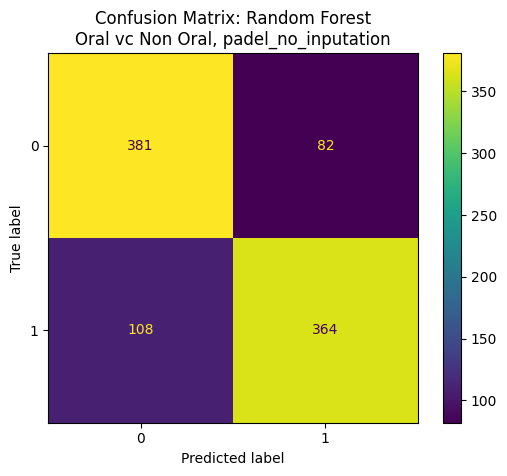

In [57]:
disp.plot()
plt.title(f"Confusion Matrix: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}")
disp.figure_.savefig(f"imgs/cm_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)
plt.show()

## ROC/AUC

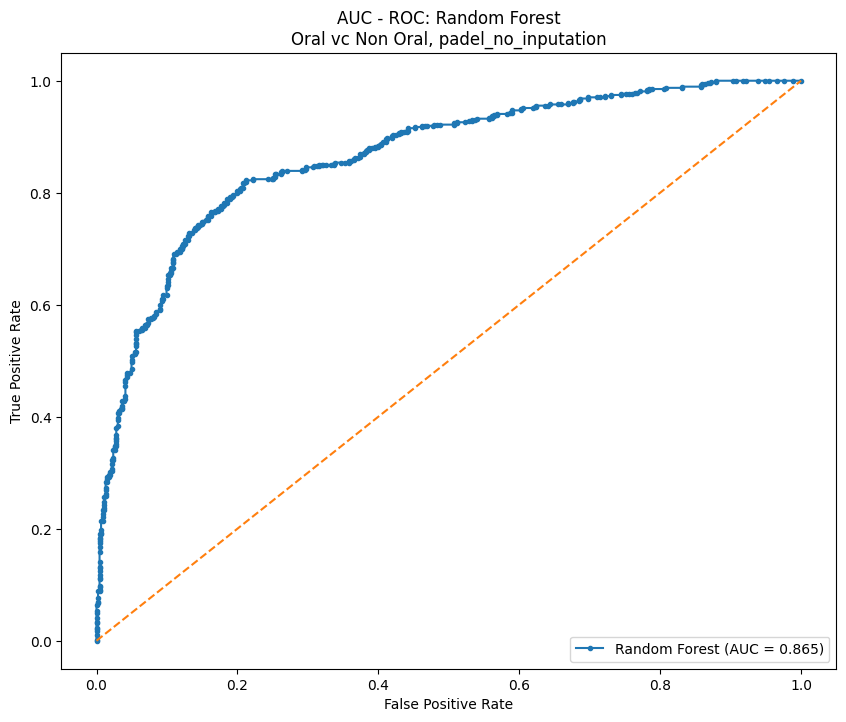

In [58]:
auc_rf = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_rf_prob,
    model_name=model_name_title,
    title=f"AUC - ROC: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}",
    save_path=f"imgs/roc_auc_{DESCRIPTOR_TYPE}_{model_name_path}"
)

## Feature Importance

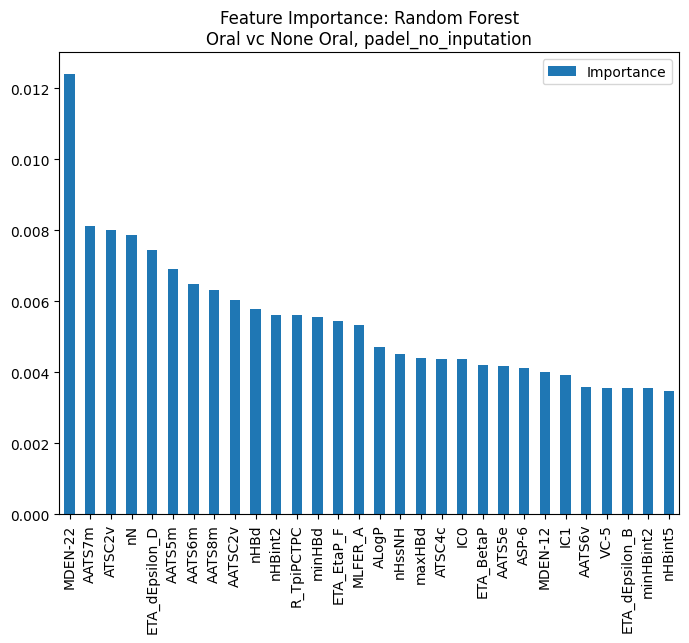

In [59]:
# Print the feature importances

fig, ax = plt.subplots(1, 1)

feat_importances = pd.DataFrame(random_forest.feature_importances_, index=x_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)

feat_importances.iloc[:30,:].plot(kind='bar', figsize=(8,6), ax=ax)
ax.set_title(f"Feature Importance: {model_name_title}\nOral vc None Oral, {DESCRIPTOR_TYPE}")

fig.savefig(f"imgs/feature_importance_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)

In [60]:
important_features_rf = feat_importances[feat_importances.Importance > 0].sort_values(by="Importance")
important_features_rf

,Importance
ndssS,0.000001
maxsSH,0.000002
ndsssAs,0.000003
maxsI,0.000004
nddC,0.000004
...,...
ETA_dEpsilon_D,0.007459
nN,0.007856
ATSC2v,0.008000
AATS7m,0.008123


## Saving Results

In [61]:
final_results.loc[len(final_results.index)] = [
    model_name_title,
    gs_result_rf["best_score"][0],
    mis_rate_rf_train,
    mis_rate_rf,
    auc_rf_train,
    auc_rf
]
final_results

,model_name,cv_test_auc,training_mis_rate,test_mis_rate,training_auc,test_auc
0,Logistic Regression,0.661820,0.160542,0.265241,0.839463,0.802545
1,Decision Tree,0.753712,0.251516,0.313369,0.747928,0.769393
2,Random Forest,0.861295,0.001070,0.203209,0.998940,0.865066


In [62]:
important_features_rf.to_csv(f"final_results/important_features_{model_name_path}_{DESCRIPTOR_TYPE}.csv", index=False)

# Boosting

## Model Constant Variables

In [63]:
model_name_title = "Gradiant Boosting"
model_name_path = "boosting"

## Hyperparameter Fine Tuning

In [64]:
model_params = {
    'Boosting': {
            'model': GradientBoostingClassifier(),
            'params': {
                'n_estimators' : [100, 500], # number of trees
                'learning_rate': [0.01, 0.1], # alfa
                'max_depth': [20],
        }
    }
}

In [65]:
gs_result_boo, gs_result_boo_full = best_params_grid(x_train_scaled, y_train, model_params)

Starting Grid Search for Boosting: 13:43
Finished Grid Search for Boosting: 21:36
Tempo de execução:  472.9 minutos


In [66]:
gs_result_boo

,model,best_score,best_params
0,Boosting,0.801058,"{'learning_rate': 0.1, 'max_depth': 20, 'n_est..."


## Fitting Model

In [67]:
boosting_params = gs_result_boo.iloc[0,2]
boosting_params

{'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 500}

In [68]:
boosting = GradientBoostingClassifier(**boosting_params).fit(x_train, y_train)

## Get Training Error and AUC

In [69]:
mis_rate_boo_train, auc_boo_train = get_error_and_auc(
    model=boosting, 
    x=x_train,
    y_true=y_train,
)

Training Misclassification Rate: 0.0011
Training AUC: 0.9989


## Make Prediction

In [70]:
y_predict_boo_label = boosting.predict(x_test)
y_predict_boo_prob = boosting.predict_proba(x_test)[:, 1]

## Test Error

In [71]:
mis_rate_boo, disp = calculate_confusion_matrix(
    y_test=y_test, 
    y_pred=y_predict_boo_label,
)

Misclassification rate: 0.3005


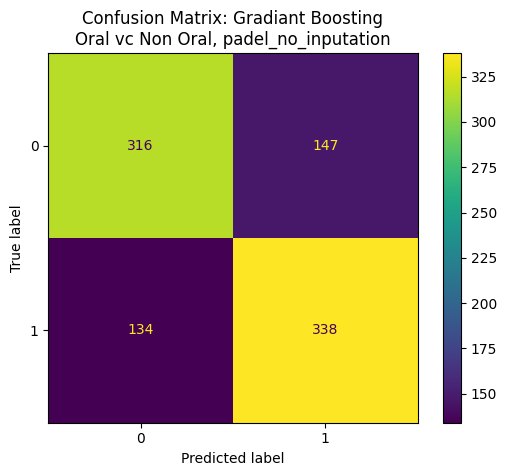

In [72]:
disp.plot()
plt.title(f"Confusion Matrix: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}")
disp.figure_.savefig(f"imgs/cm_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)
plt.show()

## ROC/AUC

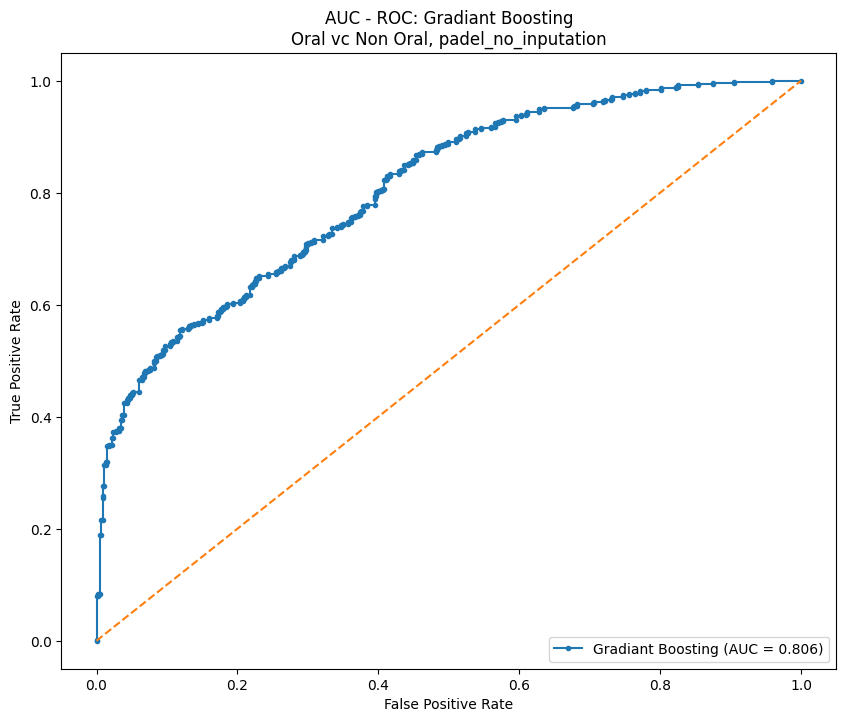

In [73]:
auc_boo = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_boo_prob,
    model_name=model_name_title,
    title=f"AUC - ROC: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}",
    save_path=f"imgs/roc_auc_{DESCRIPTOR_TYPE}_{model_name_path}"
)

## Feature Importance

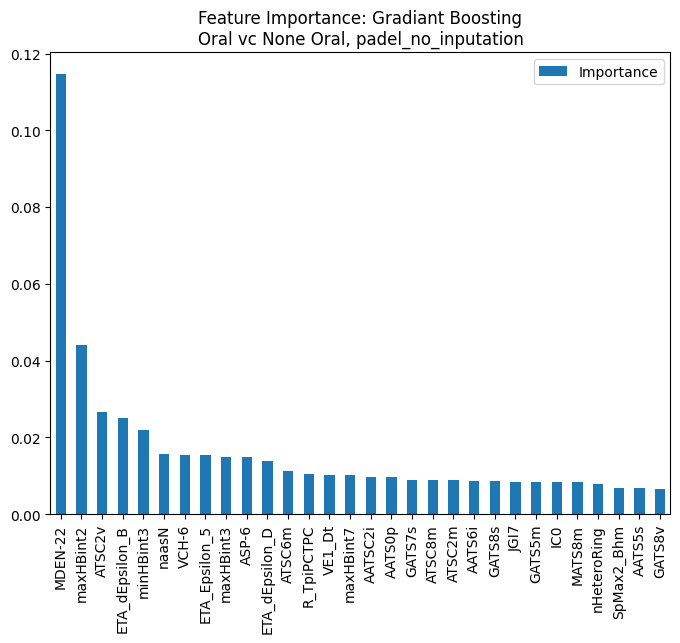

In [74]:
# Print the feature importances

fig, ax = plt.subplots(1, 1)

feat_importances = pd.DataFrame(boosting.feature_importances_, index=x_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)

feat_importances.iloc[:30,:].plot(kind='bar', figsize=(8,6), ax=ax)
ax.set_title(f"Feature Importance: {model_name_title}\nOral vc None Oral, {DESCRIPTOR_TYPE}")

fig.savefig(f"imgs/feature_importance_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)

In [75]:
important_features_boo = feat_importances[feat_importances.Importance > 0].sort_values(by="Importance")
important_features_boo

,Importance
nG12Ring,1.481808e-21
nF6Ring,4.610110e-20
SssS,1.772323e-19
ETA_dPsi_B,2.510324e-19
n4Ring,1.460571e-18
...,...
minHBint3,2.196668e-02
ETA_dEpsilon_B,2.519455e-02
ATSC2v,2.673505e-02
maxHBint2,4.408047e-02


## Saving Results

In [76]:
final_results.loc[len(final_results.index)] = [
    model_name_title,
    gs_result_boo["best_score"][0],
    mis_rate_boo_train,
    mis_rate_boo,
    auc_boo_train,
    auc_boo
]
final_results

,model_name,cv_test_auc,training_mis_rate,test_mis_rate,training_auc,test_auc
0,Logistic Regression,0.661820,0.160542,0.265241,0.839463,0.802545
1,Decision Tree,0.753712,0.251516,0.313369,0.747928,0.769393
2,Random Forest,0.861295,0.001070,0.203209,0.998940,0.865066
3,Gradiant Boosting,0.801058,0.001070,0.300535,0.998933,0.806123


In [77]:
important_features_boo.to_csv(f"final_results/important_features_{model_name_path}_{DESCRIPTOR_TYPE}.csv", index=False)

# BART

## Model Constant Variables

In [78]:
model_name_title = "BART"
model_name_path = "bart"

## Hyperparameter Fine Tuning

In [79]:
# transforming x train and test as arrays for BART procedure

x_train_bart = np.asarray(x_train)
x_test_bart = np.asarray(x_test)

In [80]:
model_params = {
    'BART': {
        'model': BART(),
        'params': {
            'num_trees': [100, 500, 1000],
            'max_stages': [100, 500, 800, 1000], # B, number of iterations
            'burnin': [5, 10, 20]
        }
    }
}

For BART, the auc present in the best_params_grid need to recieve the y_predicted in labels, but this BART algorithm does it in probabilities. Because of this, I need to use a custom scorer, that first transforms the prediction to labels.

In [81]:
score = make_scorer(bart_auc_scorer, greater_is_better=True)

gs_result_bart, gs_result_bart_full = best_params_grid(x_train_bart, y_train, model_params, scoring=score)

Starting Grid Search for BART: 21:45
Finished Grid Search for BART: 03:58
Tempo de execução:  372.5 minutos


In [82]:
gs_result_bart

,model,best_score,best_params
0,BART,0.748538,"{'burnin': 10, 'max_stages': 500, 'num_trees':..."


# Fitting Model

In [83]:
bart_params = gs_result_bart.iloc[0,2]
bart_params

{'burnin': 10, 'max_stages': 500, 'num_trees': 1000}

In [84]:
bart = BART(**bart_params)
bart.fit(x_train_bart, y_train)

BART(burnin=10, max_stages=500, num_trees=1000)

## Get Training Error and AUC

In [85]:
mis_rate_bart_train, auc_bart_train = get_error_and_auc(
    model=bart, 
    x=x_train_bart,
    y_true=y_train,
    transform_prob_into_label=True
)

Training Misclassification Rate: 0.1959
Training AUC: 0.8039


## Make Prediction

In [86]:
# the bart algorithm predicts as probabilities
y_predict_bart_prob = bart.predict(x_test_bart)

In [87]:
# here I use the make_label function to transform the probabilities into labels, using 0.5 as a cutoff

y_predict_bart_label = make_label_v(y_predict_bart_prob)

## Test Error

In [88]:
mis_rate_bart, disp = calculate_confusion_matrix(
    y_test=y_test, 
    y_pred=y_predict_bart_label,
)

Misclassification rate: 0.2374


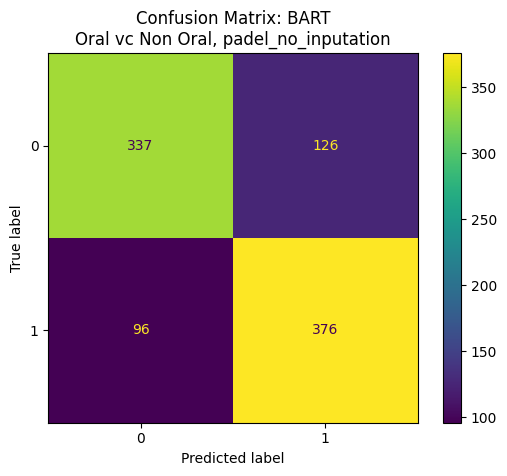

In [89]:
disp.plot()
plt.title(f"Confusion Matrix: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}")
disp.figure_.savefig(f"imgs/cm_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)
plt.show()

## ROC/AUC

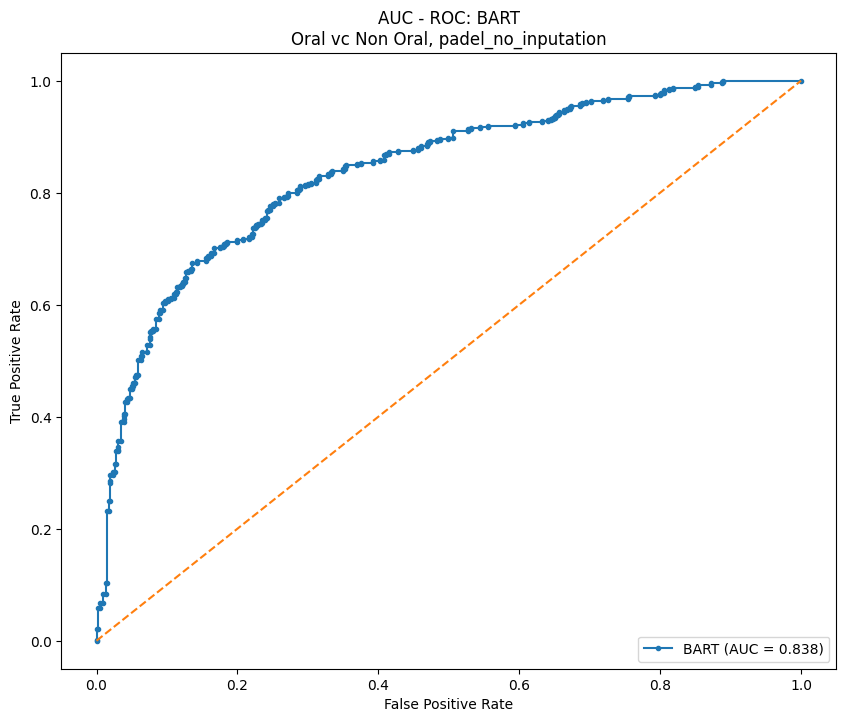

In [90]:
auc_bart = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_bart_prob,
    model_name=model_name_title,
    title=f"AUC - ROC: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}",
    save_path=f"imgs/roc_auc_{DESCRIPTOR_TYPE}_{model_name_path}"
)

## Feature Importance

We can check how many times each variable appeared in the collection
of trees. This gives a summary similar to the variable importance plot for
boosting and random forests.

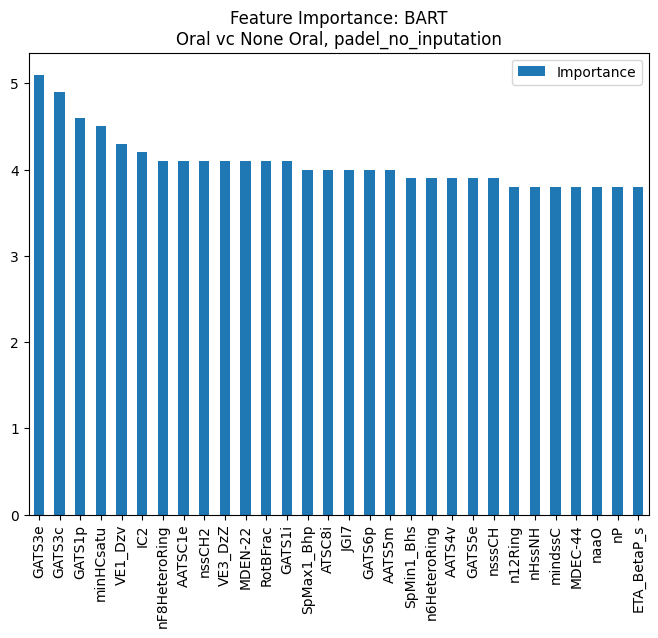

In [91]:
# Print the feature importances
fig, ax = plt.subplots(1, 1)

feat_importances = pd.DataFrame(columns=["Importance"])
feat_importances["Importance"] = pd.Series(bart.variable_inclusion_.mean(0),index=X.columns).sort_values(ascending=False)

feat_importances.iloc[:30,:].plot(kind='bar', figsize=(8,6), ax=ax)
ax.set_title(f"Feature Importance: {model_name_title}\nOral vc None Oral, {DESCRIPTOR_TYPE}")

fig.savefig(f"imgs/feature_importance_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)


In [92]:
important_features_bart = feat_importances[feat_importances.Importance > 0].sort_values(by="Importance")
important_features_bart

,Importance
AATSC3m,1.1
GATS8v,1.4
maxssssC,1.4
GATS3i,1.5
ETA_AlphaP,1.5
...,...
VE1_Dzv,4.3
minHCsatu,4.5
GATS1p,4.6
GATS3c,4.9


## Saving Results

In [93]:
final_results.loc[len(final_results.index)] = [
    model_name_title,
    gs_result_bart["best_score"][0],
    mis_rate_bart_train,
    mis_rate_bart,
    auc_bart_train,
    auc_bart
]
final_results

,model_name,cv_test_auc,training_mis_rate,test_mis_rate,training_auc,test_auc
0,Logistic Regression,0.661820,0.160542,0.265241,0.839463,0.802545
1,Decision Tree,0.753712,0.251516,0.313369,0.747928,0.769393
2,Random Forest,0.861295,0.001070,0.203209,0.998940,0.865066
3,Gradiant Boosting,0.801058,0.001070,0.300535,0.998933,0.806123
4,BART,0.748538,0.195862,0.237433,0.803897,0.837752


In [94]:
important_features_bart.to_csv(f"final_results/important_features_{model_name_path}_{DESCRIPTOR_TYPE}.csv", index=False)

# SVM

## Model Constant Variables

In [95]:
model_name_title = "SVM"
model_name_path = "svm"

## Hyperparameter Fine Tuning

In [96]:
scale = 1 / (x_train.shape[1] * x_train.var().mean())

model_params = {
    'SVM': {
        'model': SVC(),
        'params': {
            'C': [0.1, 0.3, 0.5, 0.8, 1.0, 2, 5, 10],
            'kernel': ['rbf', 'sigmoid'],
            'gamma': ['auto', scale, 0.0001, 0.001, 0.01, 0.1, 0.5, 1, 10]
        }
    }
}

In [97]:
gs_result_svm, gs_result_svm_full = best_params_grid(x_train, y_train, model_params)

Starting Grid Search for SVM: 03:59
Finished Grid Search for SVM: 07:10
Tempo de execução:  191.5 minutos


## Fitting Model

In [98]:
svm_params = gs_result_svm.iloc[0,2]
svm_params

{'C': 0.1, 'gamma': 8.927146686527179e-16, 'kernel': 'sigmoid'}

In [99]:
svm = SVC(**svm_params, probability=True).fit(x_train, y_train)

## Get Training Error and AUC

In [100]:
mis_rate_svm_train, auc_svm_train = get_error_and_auc(
    model=svm, 
    x=x_train,
    y_true=y_train,
)

Training Misclassification Rate: 0.4952
Training AUC: 0.5000


## Make Prediction

In [101]:
y_predict_svm_label = svm.predict(x_test)
y_predict_svm_prob = svm.predict_proba(x_test)[:, 1]

## Test Error

In [102]:
mis_rate_svm, disp = calculate_confusion_matrix(
    y_test=y_test, 
    y_pred=y_predict_svm_label,
)

Misclassification rate: 0.4952


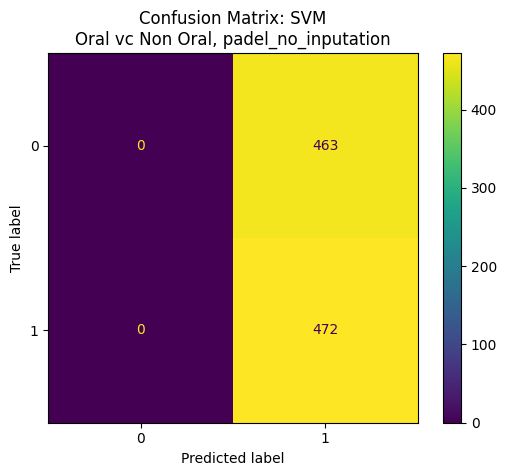

In [103]:
disp.plot()
plt.title(f"Confusion Matrix: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}")
disp.figure_.savefig(f"imgs/cm_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)
plt.show()

## ROC/AUC

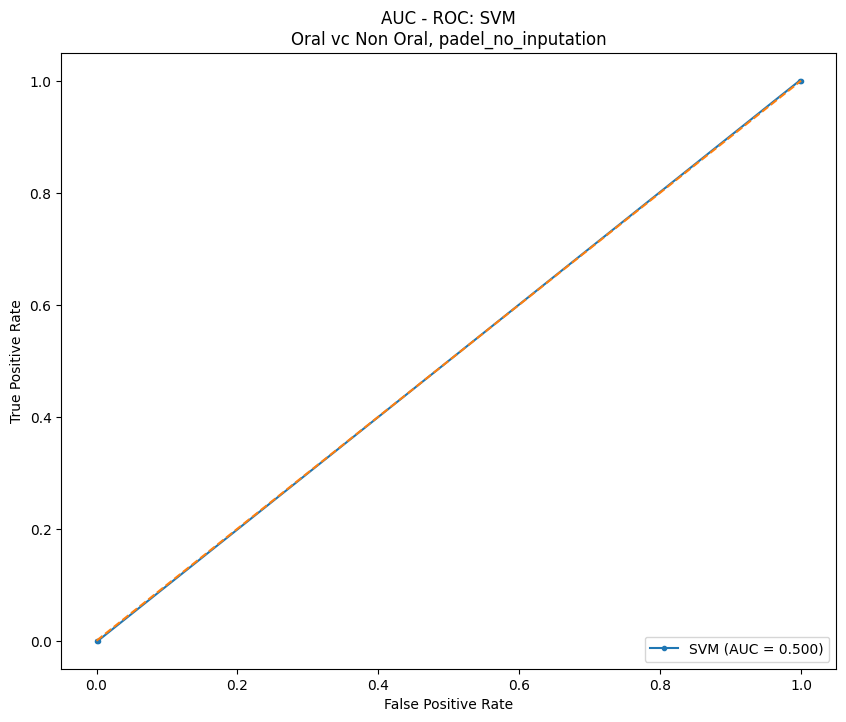

In [104]:
auc_svm = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_svm_prob,
    model_name=model_name_title,
    title=f"AUC - ROC: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}",
    save_path=f"imgs/roc_auc_{DESCRIPTOR_TYPE}_{model_name_path}"
)

## Saving Results

In [105]:
final_results.loc[len(final_results.index)] = [
    model_name_title,
    gs_result_svm["best_score"][0],
    mis_rate_svm_train,
    mis_rate_svm,
    auc_svm_train,
    auc_svm
]
final_results

,model_name,cv_test_auc,training_mis_rate,test_mis_rate,training_auc,test_auc
0,Logistic Regression,0.661820,0.160542,0.265241,0.839463,0.802545
1,Decision Tree,0.753712,0.251516,0.313369,0.747928,0.769393
2,Random Forest,0.861295,0.001070,0.203209,0.998940,0.865066
3,Gradiant Boosting,0.801058,0.001070,0.300535,0.998933,0.806123
4,BART,0.748538,0.195862,0.237433,0.803897,0.837752
5,SVM,0.605705,0.495184,0.495187,0.500000,0.500000


# Saving Final Datasets

In [106]:
# saving final_results dataset
final_results.to_csv(f"final_results/models_results_{DESCRIPTOR_TYPE}.csv", index=False)

In [107]:
session_info.show()